In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def calculate_abnormal_imbalance(df, window=100, future_periods=10, threshold_std=1.0, col='volume'):
    """
    计算异常后不平衡表现因子
    步骤：
    1. 在滚动窗口内剔除前后5%极值后计算均值和标准差
    2. 识别当前值超过均值+阈值倍标准差的异常点
    3. 统计异常点数量
    4. 计算每个异常点后N周期的收益率序列
    5. 计算正收益均值 - 负收益均值的不平衡值
    6. 因子值 = 异常点数量 × 平均不平衡值
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 滚动窗口大小(默认100)
    future_periods: 未来观察周期(默认10)
    threshold_std: 异常阈值倍数(默认1.0)
    col: 分析的目标列(默认volume)
    """
    # 计算每个周期的简单收益率 (close - open)/open
    df = df.copy()
    df['period_return'] = (df['close'] - df['open']) / df['open']
    
    # 初始化结果数组
    factor_values = np.zeros(len(df))
    factor_values[:] = np.nan  # 前期数据不足设为NaN
    
    # 遍历每个可计算的时间点(从window+future_periods开始)
    for i in range(window + future_periods, len(df)):
        # 获取滚动窗口数据(剔除当前点)
        window_data = df.iloc[i-window:i-1]
        
        # 剔除前后5%极值
        q05 = window_data[col].quantile(0.05)
        q95 = window_data[col].quantile(0.95)
        trimmed = window_data[(window_data[col] >= q05) & (window_data[col] <= q95)]
        
        # 计算均值和标准差
        mean_val = trimmed[col].mean()
        std_val = trimmed[col].std()
        
        # 识别异常点(当前值超过均值+阈值倍标准差)
        current_val = df[col].iloc[i]
        is_abnormal = current_val > (mean_val + threshold_std * std_val)
        
        if not is_abnormal:
            factor_values[i] = 0
            continue
        
        # 获取异常点后的收益率序列
        future_returns = df['period_return'].iloc[i+1:i+1+future_periods].dropna()
        
        if len(future_returns) == 0:
            factor_values[i] = 0
            continue
            
        # 计算不平衡值
        positive_returns = future_returns[future_returns > 0]
        negative_returns = future_returns[future_returns < 0]
        
        avg_positive = positive_returns.mean() if len(positive_returns) > 0 else 0
        avg_negative = negative_returns.mean() if len(negative_returns) > 0 else 0
        imbalance = avg_positive - abs(avg_negative)  # 注意负收益取绝对值
        
        # 因子值 = 不平衡值(简化处理)
        factor_values[i] = imbalance
        
    return pd.Series(factor_values, index=df.index)

# 创建因子计算函数(使用默认参数)
def factor_function(df):
    return calculate_abnormal_imbalance(df)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.362622
   Rank_IC (Spearman): 0.268857
📊 信息比率:
   IR: 3.454990
   有效分组数: 2
📊 因子分布:
📋 数据概况:
   数据长度: 130925
   因子列: abnormal_imbalance
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


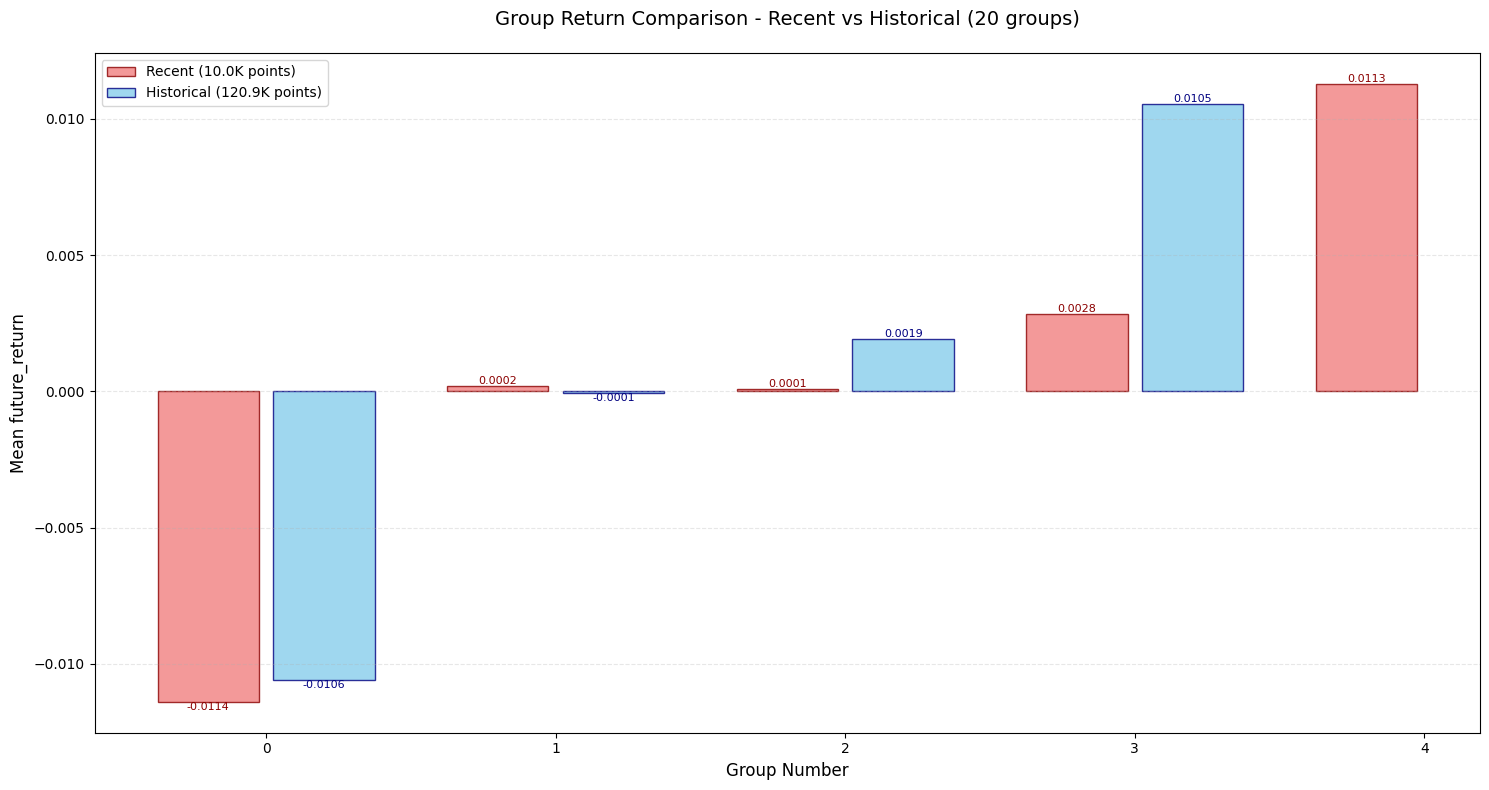

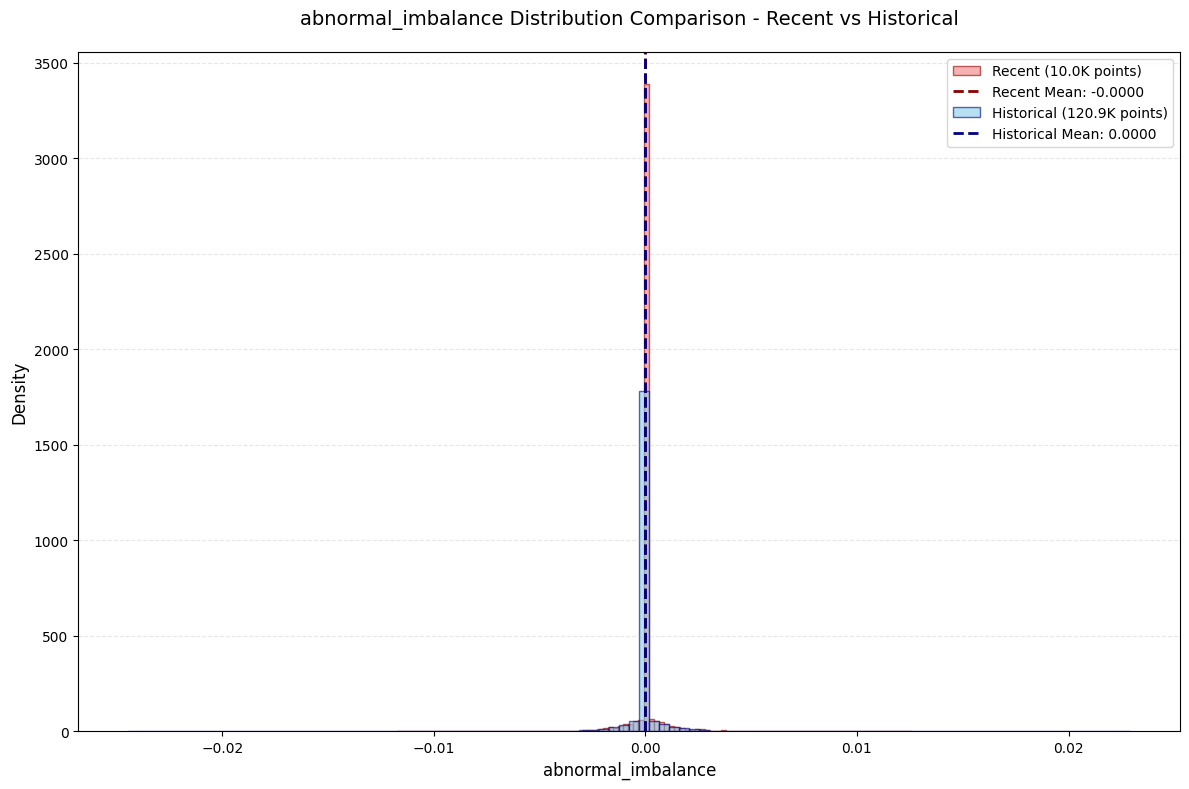

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=factor_function,
    factor_name='abnormal_imbalance'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

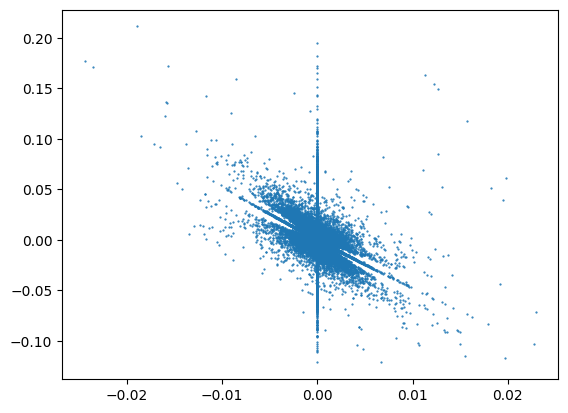

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor_function(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.28427066382575894, 0.5158566258743829]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.3626215829253433, 'Rank_IC': 0.2688570504590615}, 'information_ratio': {'IR': 3.4549904606573114, 'group_correlations': [0.28427066382575894, 0.5158566258743829], 'n_groups': 2}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std   count
group                                                             
0      -0.0244  -0.0008   -0.0022      -0.0107      0.0148    6547
1      -0.0008   0.0000   -0.0000      -0.0000      0.0108  111970
2       0.0000   0.0008    0.0004       0.0020      0.0071    5861
3       0.0008   0.0229    0.0022       0.0106      0.0157    6547, 'figure': <Figure size 1500x800 with 1 Axes>}, 'factor_distribution': {'descriptive_stats': count   130925.0000
mean         0.0000
std          0.0009
min         -0.0244
1%          -0.0029
5%          -0.0008
25%          0.0000
50%          0.0000
75%          0.0000
95%          0.0008
99%          0.0028
max          0.0229
Name: abnormal_imb